توجه: فقط قسمت های خواسته شده را تکمیل کنید و همراه فایل خود مدل آموزش دیده را ارسال کنید.

هدف این تمرین :


1.   ساخت دیتاست مورد نیاز و نوشتن کلاس دیتاست
2.   Augmentation
3.   نوشتن مدل دسته بندی 3 کلاسه با استفاده از چند کلاس پایتون



In [55]:
## download data
%%capture

!wget http://data.csail.mit.edu/places/ADEchallenge/release_test.zip
!wget http://data.csail.mit.edu/places/ADEchallenge/ADEChallengeData2016.zip
!unzip ADEChallengeData2016.zip
!unzip release_test.zip
!pip install mmengine

In [48]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import glob

from cv2 import imread as IM
from os import path

from torch.utils.data import Dataset
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import random
from torch.utils.data import random_split

from random import randint
import matplotlib.pyplot as plt

## Data Generation

در این قسمت برای ساخت دیتاست مورد نیاز باید از هر تصویر دانلود شده ،2 تصویر یکی بدون تغییر و دیگری تغییر یافته به سایز 224 در 224 تولید کنید .به این منظور ابتداتابع های 1تا 6 را کامل کرده و سپس از تابع های 1تا3 برای ساخت تصویر تغییر یافته استفاده کنید.توجه داشته باشید که در تصاویر تولیدی تعدادی فقط یک تغییر و تعدادی دو و سه تغییر را باید داشته باشند،همچنین در تصاویر تولید شده نباید قسمت مشکی ناشی از چرخش وجود داشته باشد




In [56]:
import torchvision.transforms.functional as TF

# function 1
def displacement(img):
  ## To Do
    img = img.numpy().transpose(1,2,0)
    translated_img = torch.tensor(cv2.warpAffine(img,
                                                 np.float32([[1, 0, np.random.randint(60,100)], [0, 1, np.random.randint(60,100)]]),
                                    (img.shape[1], img.shape[0]),borderMode=cv2.BORDER_REFLECT).transpose(2,0,1))
    return translated_img

# function 2
def rotation(img):
    ## To Do
    img = img.numpy().transpose(1,2,0)
    # Apply the rotation to the image
    rotated_img = torch.from_numpy(cv2.warpAffine(img, cv2.getRotationMatrix2D((img.shape[1]/2, img.shape[0]/2),
                                                                               np.random.randint(-60, 60), 1),
                                                                                (img.shape[1], img.shape[0]),
                                                  borderMode=cv2.BORDER_REFLECT).transpose(2,0,1))
    return rotated_img


# function 3
def scaling(img):
  ## To Do
    return v2.RandomAffine(degrees=0, scale=(1, 4))(img)




# function 4
def Brightness(img):  ## for augmentation
  ## To Do
  return TF.adjust_brightness(img, np.random.uniform(0.5, 1.))



# function 5
def bluring(img):# for augmentation
  ## To Do
  return v2.GaussianBlur(kernel_size=(7, 7), sigma=(0.1, 5.))(img)


# function 6
def gaussian_noise(img):#for augmentation
  ## To Do
    return img.type(torch.float64).add_(torch.from_numpy(np.random.normal(0, 20, size=img.shape))).type(img.dtype)






In [57]:
from PIL import Image
import torchvision.transforms as v2

class CustomDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.images = os.listdir(data_dir)

    def __getitem__(self, idx):
        img = Image.open(os.path.join(self.data_dir, self.images[idx]))

        if self.transform:
            img = self.transform(img)

        if img.shape[0] == 1:
            img = img.expand(3, -1, -1)

        changed_img = img.clone()
        transforms = [displacement, rotation, scaling]

        # apply 1, 2, or 3 transformations
        num_transformations = np.random.randint(1, 4)
        label = torch.zeros(3, device=img.device)
        indices = np.random.choice(3, size=num_transformations, replace=False)
        label[indices] = 1

        for index, a in enumerate(label):
            if a > 0.5:
                transform_function = transforms[index]
                changed_img = transform_function(changed_img)

        return v2.Resize((224, 224), antialias=True)(img), v2.Resize((224, 224), antialias=True)(changed_img), label

    def __len__(self):
        return len(self.images)


In [58]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [59]:



# extend train dataset with  augmentation
dataset_train = torch.utils.data.Subset(torch.utils.data.ConcatDataset([CustomDataset('/content/ADEChallengeData2016/images/training',transform=v2.Compose([v2.PILToTensor()])),
                                                CustomDataset('/content/ADEChallengeData2016/images/training',transform=v2.Compose([
    v2.PILToTensor(), Brightness, gaussian_noise,bluring]))]),[i for i in range(4096)] )## To Do

dataset_test = CustomDataset('/content/release_test/testing',transform=v2.Compose([v2.PILToTensor()]))## To Do
dataset_val = CustomDataset('/content/ADEChallengeData2016/images/validation',transform=v2.Compose([v2.PILToTensor()]))## To Do

train_loader = DataLoader(dataset_train,batch_size=16, shuffle=True)## To Do

test_loader= DataLoader(dataset_test,batch_size=16, shuffle=True)## To Do
val_loader = DataLoader(dataset_val,batch_size=16, shuffle=True)## To Do






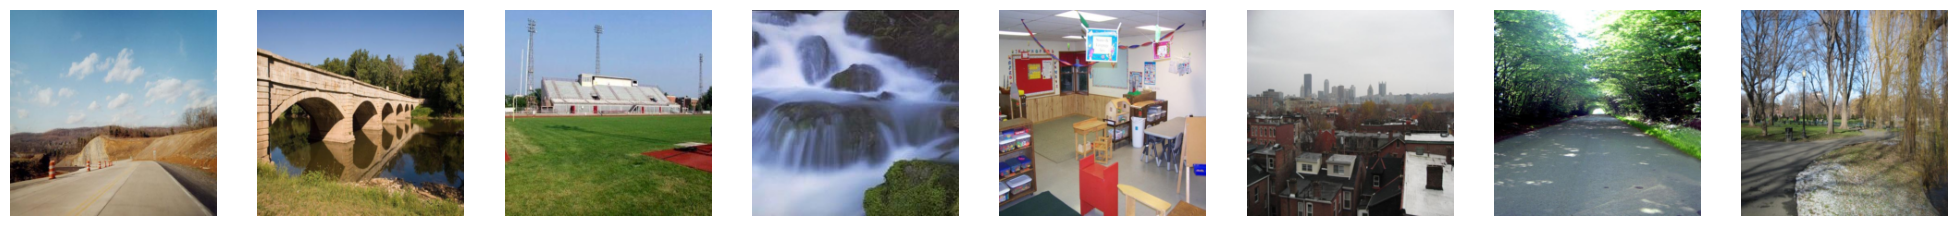

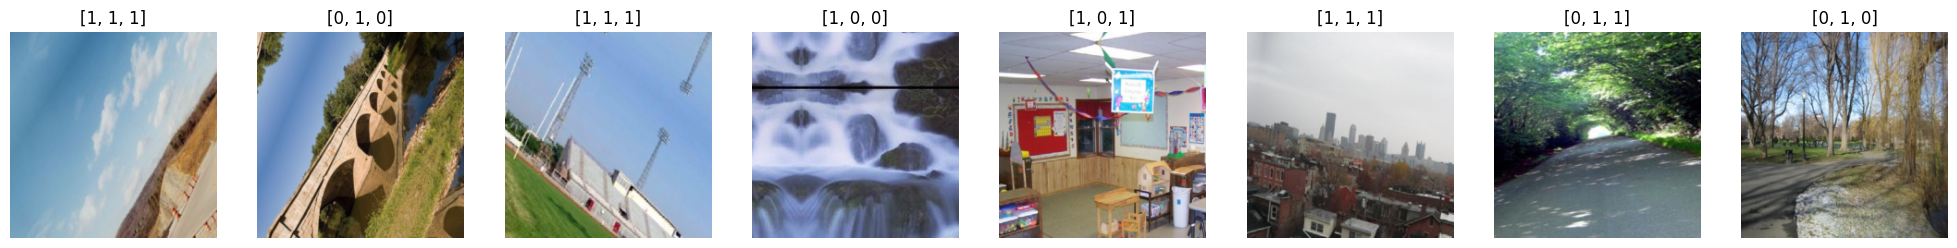

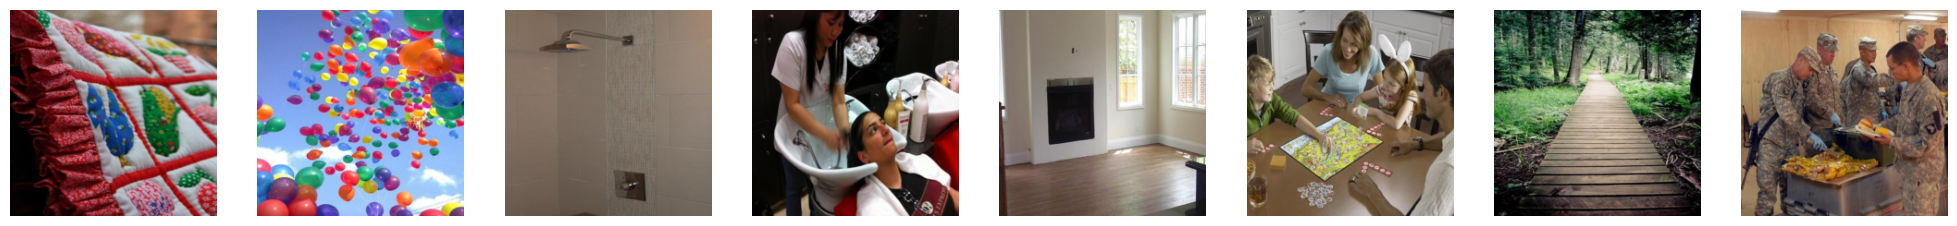

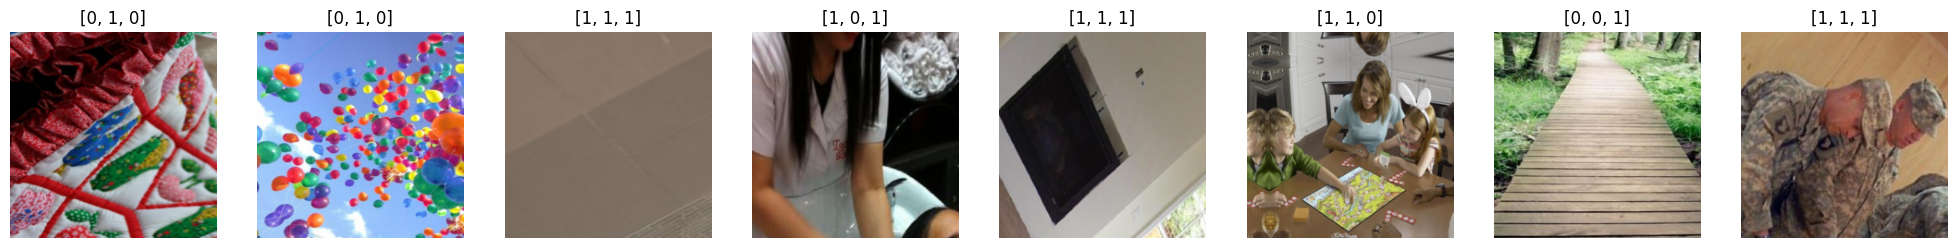

In [60]:
## To Do  : show 8 images from train_loader & 8 images from test_loader
# Function to display images

def show_image(images, title='', label=None):
    # Function to plot multiple images
    num_images = len(images)
    fig, axes = plt.subplots(1, num_images, figsize=(25, 25))

    for i, ax in enumerate(axes):
        ax.imshow(images[i].permute(1, 2, 0))  # Assuming images are PyTorch tensors
        ax.axis('off')
        if label is not None:
            ax.set_title([int(x) for x in label[i].tolist()])



# Assuming train_loader is your data loader

samples, trans_samples, labels = next(iter(train_loader))
indices = np.arange(8) + np.random.randint(1, 6)

show_image(samples[indices], title='Training data')
show_image(trans_samples[indices], title='Transformed Data', label=labels[indices])

samples, trans_samples, labels = next(iter(test_loader))
indices = np.arange(8) + np.random.randint(1, 6)

show_image(samples[indices], title='Testing data')
show_image(trans_samples[indices], title='Transformed Data', label=labels[indices])


##Model

در این قسمت میخواهیم یک مدل 3 کلاسه  مطبق شکل زیرکه شامل قسمت های زیر میشود را آموزش دهیم.

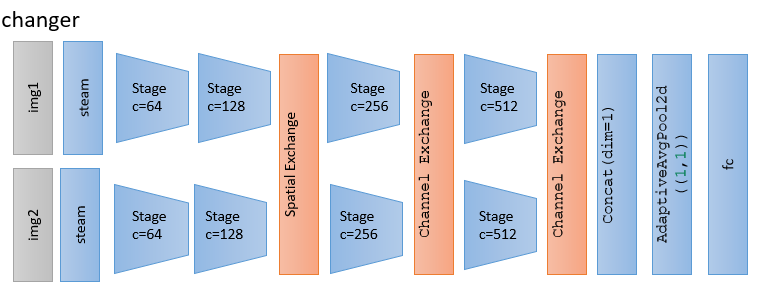

دو کلاس



1.   SpatialExchange
2.   ChannelExchange


 .مطابق شکل زیر ویژگی های دو تصویر را با هم عوض میکنند.


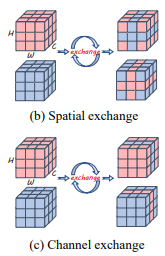

In [61]:
## dont change this block

from mmengine.model import BaseModule
class ChannelExchange(BaseModule):
    """
    channel exchange
    Args:
        p (float, optional): p of the features will be exchanged.
            Defaults to 1/2.
    """
    def __init__(self, p=1/2):
        super().__init__()
        assert p >= 0 and p <= 1
        self.p = int(1/p)

    def forward(self, x1, x2):
        N, c, h, w = x1.shape

        exchange_map = torch.arange(c) % self.p == 0
        exchange_mask = exchange_map.unsqueeze(0).expand((N, -1))

        out_x1, out_x2 = torch.zeros_like(x1), torch.zeros_like(x2)
        out_x1[~exchange_mask, ...] = x1[~exchange_mask, ...]
        out_x2[~exchange_mask, ...] = x2[~exchange_mask, ...]
        out_x1[exchange_mask, ...] = x2[exchange_mask, ...]
        out_x2[exchange_mask, ...] = x1[exchange_mask, ...]

        return out_x1, out_x2



class SpatialExchange(BaseModule):
    """
    spatial exchange
    Args:
        p (float, optional): p of the features will be exchanged.
            Defaults to 1/2.
    """
    def __init__(self, p=1/2):
        super().__init__()
        assert p >= 0 and p <= 1
        self.p = int(1/p)

    def forward(self, x1, x2):
        N, c, h, w = x1.shape
        exchange_mask = torch.arange(w) % self.p == 0

        out_x1, out_x2 = torch.zeros_like(x1), torch.zeros_like(x2)
        out_x1[..., ~exchange_mask] = x1[..., ~exchange_mask]
        out_x2[..., ~exchange_mask] = x2[..., ~exchange_mask]
        out_x1[..., exchange_mask] = x2[..., exchange_mask]
        out_x2[..., exchange_mask] = x1[..., exchange_mask]

        return out_x1, out_x2

شبکه ی زیر را پیاده کنید  

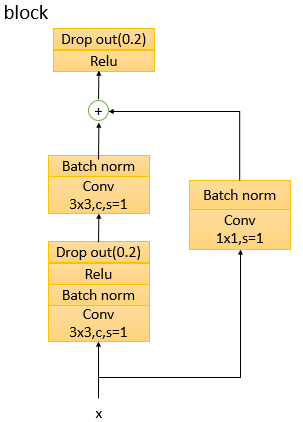

سوال تئوری1:
1.  مقادیر زیر را برای لایه های کانولوشن چه قدر در نظر گرفته اید؟
 channel out size (conv(1*1))
 padding(conv)
2.  دلیل استفاده از کانولوشن 1در1 چیست؟





In [62]:
##To Do
class block(nn.Module):
  def __init__(self,in_channels, out_channels):
    super(block,self).__init__()
    # Define the layers
    self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3,padding=1)
    self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,padding=1)
    self.conv3 = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    self.batchnorm1 = nn.BatchNorm2d(out_channels)
    self.batchnorm2 = nn.BatchNorm2d(out_channels)
    self.batchnorm3 = nn.BatchNorm2d(out_channels)

    self.dropout = nn.Dropout2d(p=0.2)
    self.relu = nn.ReLU()

  def forward(self,x):
    out = self.dropout(self.relu(self.batchnorm1(self.conv1(x))))
    out = self.batchnorm2(self.conv2(out))
    out_byPass = self.batchnorm3(self.conv3(x))

    out = self.dropout(self.relu(out + out_byPass))

    return out

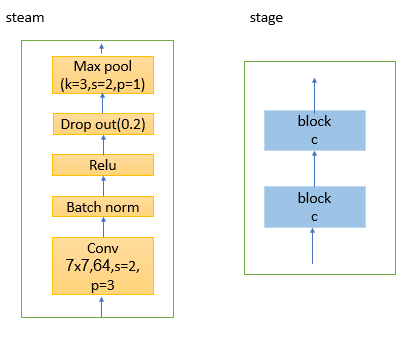

با استفاده از تصاویر مدل ،کلاس زیر را تکمیل کنید.

In [63]:
#To Do
class changer(nn.Module):
  def __init__(self,block,SpatialExchange,ChannelExchange,in_channels):
    super(changer,self).__init__()

    self.steam=nn.Sequential(
        nn.Conv2d(in_channels, 64, kernel_size=7,padding=3,stride=2),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.Dropout2d(p=0.2),
        nn.MaxPool2d(kernel_size=3,padding=1,stride=2)
        )
    self.in_channels = in_channels
    self.SpatialExchange = SpatialExchange()
    self.ChannelExchange1 = ChannelExchange()
    self.ChannelExchange2 = ChannelExchange()
    self.block = block

    self.stage1 = self._make_stage(64)
    self.stage2 = self._make_stage(128)
    self.stage3 = self._make_stage(256)
    self.stage4 = self._make_stage(512,same_channel=True)

    self.AdaptiveAvgPool2d = nn.AdaptiveAvgPool2d((1,1))
    self.fc = nn.Linear(1024, 3)
    self.sigmoid = nn.Sigmoid()

  def _make_stage(self,out_channels,same_channel=False):
    layers = [self.block(out_channels, out_channels), self.block(out_channels, out_channels * (1 if same_channel else 2))]
    return nn.Sequential(*layers)




  def forward(self,x1,x2):
    out1,out2 = self.SpatialExchange(self.stage2(self.stage1(self.steam(x1))),self.stage2(self.stage1(self.steam(x2))))
    out1 ,out2 = self.ChannelExchange1(self.stage3(out1),self.stage3(out2))
    out1 ,out2 = self.ChannelExchange2(self.stage4(out1),self.stage4(out2))

    return self.sigmoid(self.fc(self.AdaptiveAvgPool2d(torch.concat([out1,out2],dim=1)).view(self.AdaptiveAvgPool2d(torch.concat([out1,out2],dim=1)).shape[0],-1)))


In [64]:
## To Do
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = changer(block,SpatialExchange,ChannelExchange,in_channels=3).to(device)
optimizer = optim.RMSprop(model.parameters(), lr=0.001, alpha=0.09)


##Train & validation


In [65]:
import copy
import time
from collections import defaultdict
from tqdm import tqdm

def train_custom_model(custom_model, custom_optimizer, num_epochs=8):
    custom_output_metrics = {'loss': {'train': [], 'val': []},
                             'displacement accuracy': {'train': [], 'val': []},
                             'rotation accuracy': {'train': [], 'val': []},
                             'scaling accuracy': {'train': [], 'val': []},
                             }

    all_metrics = ['loss', 'displacement accuracy', 'rotation accuracy', 'scaling accuracy']

    custom_dataloaders = {
        'train': train_loader,
        'val': val_loader}
    best_custom_model_wts = copy.deepcopy(custom_model.state_dict())
    best_loss = 1e10

    custom_epoch_loss = 0
    losses = []
    criterion = torch.nn.BCELoss()

    for custom_epoch in range(num_epochs):
        print(f"Training Epoch {custom_epoch}/{num_epochs - 1}\n{'-' * 20}")

        since = time.time()

        # Each epoch has a training and validation phase
        for custom_phase in ['train', 'val']:
            if custom_phase == 'train':
                for param_group in custom_optimizer.param_groups:
                    print("LR", param_group['lr'])

                custom_model.train()  # Set model to training mode
            else:
                custom_model.eval()  # Set model to evaluate mode

            metrics = defaultdict(float)
            custom_epoch_samples = 0

            accuracy_displacement = 0.0
            accuracy_rotation = 0.0
            accuracy_scaling = 0.0

            for index, (img, augmented_img, labels) in enumerate(tqdm(custom_dataloaders[custom_phase])):
                img = img.to(torch.device("cuda" if torch.cuda.is_available() else "cpu")).float()
                augmented_img = augmented_img.to(torch.device("cuda" if torch.cuda.is_available() else "cpu")).float()
                labels = labels.to(torch.device("cuda" if torch.cuda.is_available() else "cpu")).float()

                # zero the parameter gradients
                custom_optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(custom_phase == 'train'):
                    outputs = custom_model(img, augmented_img)
                    loss = criterion(outputs, labels)
                    metrics['loss'] += loss.data.cpu().numpy() * labels.size(0)
                    # backward + optimize only if in training phase
                    if custom_phase == 'train':
                        loss.backward()
                        custom_optimizer.step()

                predicted = (outputs > 0.5).float()

                # Assuming predicted and labels are numpy arrays or can be converted to numpy arrays
                for i in range(3):  # Loop for displacement, rotation, scaling
                    predicted_array = predicted[:, i].cpu().numpy()
                    labels_array = labels[:, i].cpu().numpy()

                    # Calculate accuracy manually
                    correct_predictions = (predicted_array == labels_array).sum()
                    total_samples = labels_array.size
                    accuracy = correct_predictions / total_samples

                    # Update respective accuracy
                    if i == 0:
                        accuracy_displacement += accuracy * total_samples
                    elif i == 1:
                        accuracy_rotation += accuracy * total_samples
                    elif i == 2:
                        accuracy_scaling += accuracy * total_samples

                custom_epoch_samples += img.size(0)

            temp = [0, 0, 0, 0]
            temp[0] = metrics['loss'] / custom_epoch_samples
            temp[1] = accuracy_displacement / custom_epoch_samples
            temp[2] = accuracy_rotation / custom_epoch_samples
            temp[3] = accuracy_scaling / custom_epoch_samples

            for index, metric in enumerate(all_metrics):
                custom_output_metrics[metric][custom_phase].append(temp[index])

            outputs = []
            print(f'{custom_phase} phase:')
            for index, a in enumerate(temp):
                outputs.append("{} = {:4f}".format(all_metrics[index], a * 100))
                outputs.append('\n')

            print(", ".join(outputs), '\n')
            custom_epoch_loss = metrics['loss'] / custom_epoch_samples

            # deep copy the model
            if custom_phase == 'val' and custom_epoch_loss < best_loss:
                print("saving best model")
                best_loss = custom_epoch_loss
                best_custom_model_wts = copy.deepcopy(custom_model.state_dict())

        time_elapsed = time.time() - since
        print('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

        # save the checkpoint
        checkpoint = {
        'custom_epoch': custom_epoch + 1,
        'custom_model_state_dict': custom_model.state_dict(),
        'custom_optimizer_state_dict': custom_optimizer.state_dict(),
        }
        torch.save(checkpoint, f'/content/drive/My Drive/model_checkpoint{custom_epoch}.pth')

    print('Best val loss: {:4f}'.format(best_loss))

    # load best model weights
    custom_model.load_state_dict(best_custom_model_wts)
    return custom_model, custom_output_metrics

best_model, output_metrics = train_custom_model(model, optimizer, num_epochs=8)


Training Epoch 0/7
--------------------
LR 0.001


100%|██████████| 256/256 [06:43<00:00,  1.58s/it]


train phase:
loss = 65.293052, 
, displacement accuracy = 67.016602, 
, rotation accuracy = 66.772461, 
, scaling accuracy = 66.210938, 
 



100%|██████████| 125/125 [01:33<00:00,  1.33it/s]


val phase:
loss = 70.099171, 
, displacement accuracy = 65.800000, 
, rotation accuracy = 65.200000, 
, scaling accuracy = 65.150000, 
 

saving best model
8m 17s
Training Epoch 1/7
--------------------
LR 0.001


100%|██████████| 256/256 [06:51<00:00,  1.61s/it]


train phase:
loss = 65.306545, 
, displacement accuracy = 66.943359, 
, rotation accuracy = 65.356445, 
, scaling accuracy = 65.258789, 
 



100%|██████████| 125/125 [01:32<00:00,  1.34it/s]


val phase:
loss = 66.047501, 
, displacement accuracy = 65.650000, 
, rotation accuracy = 65.700000, 
, scaling accuracy = 66.950000, 
 

saving best model
8m 24s
Training Epoch 2/7
--------------------
LR 0.001


100%|██████████| 256/256 [06:52<00:00,  1.61s/it]


train phase:
loss = 63.677176, 
, displacement accuracy = 66.577148, 
, rotation accuracy = 67.041016, 
, scaling accuracy = 68.188477, 
 



100%|██████████| 125/125 [01:34<00:00,  1.33it/s]


val phase:
loss = 62.439391, 
, displacement accuracy = 65.850000, 
, rotation accuracy = 66.550000, 
, scaling accuracy = 66.650000, 
 

saving best model
8m 27s
Training Epoch 3/7
--------------------
LR 0.001


100%|██████████| 256/256 [06:51<00:00,  1.61s/it]


train phase:
loss = 63.566148, 
, displacement accuracy = 66.528320, 
, rotation accuracy = 66.162109, 
, scaling accuracy = 67.236328, 
 



100%|██████████| 125/125 [01:35<00:00,  1.31it/s]


val phase:
loss = 62.350850, 
, displacement accuracy = 68.650000, 
, rotation accuracy = 65.500000, 
, scaling accuracy = 66.000000, 
 

saving best model
8m 27s
Training Epoch 4/7
--------------------
LR 0.001


100%|██████████| 256/256 [06:53<00:00,  1.62s/it]


train phase:
loss = 62.857886, 
, displacement accuracy = 67.846680, 
, rotation accuracy = 66.479492, 
, scaling accuracy = 65.942383, 
 



100%|██████████| 125/125 [01:36<00:00,  1.30it/s]


val phase:
loss = 61.942769, 
, displacement accuracy = 66.750000, 
, rotation accuracy = 67.450000, 
, scaling accuracy = 66.000000, 
 

saving best model
8m 30s
Training Epoch 5/7
--------------------
LR 0.001


100%|██████████| 256/256 [06:57<00:00,  1.63s/it]


train phase:
loss = 62.237341, 
, displacement accuracy = 67.675781, 
, rotation accuracy = 66.748047, 
, scaling accuracy = 66.259766, 
 



100%|██████████| 125/125 [01:37<00:00,  1.29it/s]


val phase:
loss = 61.352741, 
, displacement accuracy = 71.050000, 
, rotation accuracy = 64.800000, 
, scaling accuracy = 67.250000, 
 

saving best model
8m 35s
Training Epoch 6/7
--------------------
LR 0.001


100%|██████████| 256/256 [06:57<00:00,  1.63s/it]


train phase:
loss = 61.869116, 
, displacement accuracy = 69.042969, 
, rotation accuracy = 66.137695, 
, scaling accuracy = 65.942383, 
 



100%|██████████| 125/125 [01:37<00:00,  1.29it/s]


val phase:
loss = 60.482117, 
, displacement accuracy = 70.050000, 
, rotation accuracy = 66.600000, 
, scaling accuracy = 67.250000, 
 

saving best model
8m 35s
Training Epoch 7/7
--------------------
LR 0.001


100%|██████████| 256/256 [06:57<00:00,  1.63s/it]


train phase:
loss = 60.687800, 
, displacement accuracy = 70.947266, 
, rotation accuracy = 67.211914, 
, scaling accuracy = 69.018555, 
 



100%|██████████| 125/125 [01:36<00:00,  1.30it/s]


val phase:
loss = 58.299885, 
, displacement accuracy = 74.500000, 
, rotation accuracy = 65.500000, 
, scaling accuracy = 69.150000, 
 

saving best model
8m 34s
Best val loss: 0.582999


#Test


In [70]:
def evaluate_custom_model(custom_model):
    custom_dataloader = test_loader
    criterion = torch.nn.BCELoss()

    custom_model.eval()  # Set model to evaluate mode

    metrics = defaultdict(float)
    custom_epoch_samples = 0

    custom_accuracy_displacement = 0.0
    custom_accuracy_rotation = 0.0
    custom_accuracy_scaling = 0.0

    all_custom_predicted = []
    all_custom_targets = []

    for custom_index, (custom_img, custom_augmented_img, custom_labels) in enumerate(custom_dataloader):
        custom_img = custom_img.to(torch.device("cuda" if torch.cuda.is_available() else "cpu")).float()
        custom_augmented_img = custom_augmented_img.to(torch.device("cuda" if torch.cuda.is_available() else "cpu")).float()
        custom_labels = custom_labels.to(torch.device("cuda" if torch.cuda.is_available() else "cpu")).float()

        # forward
        with torch.no_grad():
            custom_outputs = custom_model(custom_img, custom_augmented_img)
            custom_loss = criterion(custom_outputs, custom_labels)
            metrics['loss'] += custom_loss.data.cpu().numpy() * custom_labels.size(0)

        custom_predicted = (custom_outputs > 0.5).float()

        # Assuming custom_predicted and custom_labels are numpy arrays or can be converted to numpy arrays
        custom_predicted_displacement = custom_predicted[:, 0].cpu().numpy()
        custom_labels_displacement = custom_labels[:, 0].cpu().numpy()

        # Calculate custom accuracy manually for displacement
        correct_custom_displacement_predictions = (custom_predicted_displacement == custom_labels_displacement).sum()
        total_custom_displacement_samples = custom_labels_displacement.size
        custom_accuracy_displacement = correct_custom_displacement_predictions / total_custom_displacement_samples

        # Update custom_accuracy_displacement
        custom_accuracy_displacement += custom_accuracy_displacement * total_custom_displacement_samples


        # Assuming custom_predicted and custom_labels are numpy arrays or can be converted to numpy arrays
        custom_predicted_rotation = custom_predicted[:, 1].cpu().numpy()
        custom_labels_rotation = custom_labels[:, 1].cpu().numpy()

        custom_predicted_scaling = custom_predicted[:, 2].cpu().numpy()
        custom_labels_scaling = custom_labels[:, 2].cpu().numpy()

        # Calculate custom accuracy manually for rotation
        correct_custom_rotation_predictions = (custom_predicted_rotation == custom_labels_rotation).sum()
        total_custom_rotation_samples = custom_labels_rotation.size
        custom_accuracy_rotation = correct_custom_rotation_predictions / total_custom_rotation_samples

        # Update custom_accuracy_rotation
        custom_accuracy_rotation += custom_accuracy_rotation * total_custom_rotation_samples

        # Calculate custom accuracy manually for scaling
        correct_custom_scaling_predictions = (custom_predicted_scaling == custom_labels_scaling).sum()
        total_custom_scaling_samples = custom_labels_scaling.size
        custom_accuracy_scaling = correct_custom_scaling_predictions / total_custom_scaling_samples

        # Update custom_accuracy_scaling
        custom_accuracy_scaling += custom_accuracy_scaling * total_custom_scaling_samples


        all_custom_predicted.extend(custom_predicted.cpu().numpy().flatten())
        all_custom_targets.extend(custom_labels.cpu().numpy().flatten())

        custom_epoch_samples += custom_img.size(0)

    print('Evaluation results:\nLoss = {:4f}\nDisplacement accuracy = {:4f}\nRotation accuracy = {:4f}\nScaling accuracy = {:4f}'.format(metrics['loss'] / custom_epoch_samples, custom_accuracy_displacement / custom_epoch_samples* 100,
                                                                                                                                         custom_accuracy_rotation / custom_epoch_samples * 100, custom_accuracy_scaling / custom_epoch_samples * 100))

checkpoint = torch.load(f'/content/drive/My Drive/model_checkpoint{7}.pth')
model.load_state_dict(checkpoint['custom_model_state_dict'])
optimizer.load_state_dict(checkpoint['custom_optimizer_state_dict'])
epoch = checkpoint['custom_epoch']

## To Do test
evaluate_custom_model(model)


Evaluation results:
Loss = 0.592558
Displacement accuracy = 0.671241
Rotation accuracy = 0.798777
Scaling accuracy = 0.637679


سوال تئوری:
بررسی کنید عکس ها با یک ،2 یا 3 تغییر کدام بهتر تشخیص داده میشوند؟